# Data visualization tools for PhysiCell

These scripts are meant to be used to read simulation results. The goal is to store the data from the simulation files in Python data structures to then plot the results. Three different strategies are implemented:

- Single time point
- Animation with several time points
    - GIF (saved as a file)
    - Widget (visualize in the notebook)
- User interaction widget to select the time point to plot

In [14]:
# Reading data files
from pathlib import Path
import subprocess
import xml.etree.ElementTree as ET
import numpy as np
from scipy import io as sio
# Basic visualization
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from matplotlib.collections import PatchCollection
from matplotlib.colors import ListedColormap
import seaborn as sns
# User interaction and online visualization
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
from IPython.display import HTML

%matplotlib inline

## Data structures to store simulation data in Python

In [2]:
class Microenvironment:
    def __init__(self, time, storage_path):

        self.storage = storage_path

        self.time = time
        self.substances = self.get_substances()
        self.mesh = self.get_mesh()
        self.mesh_shape = (len(self.mesh[1]), len(self.mesh[0]))

        self.data = self.get_data()

    def get_substances(self):
        """Returns a list of the substances stored in the XML output files."""

        # Open the first XML file to get list of stored substances
        tree = ET.parse(self.storage / 'output00000000.xml')
        root = tree.getroot()
        var_node = root.find('microenvironment/domain/variables')
        var_children = var_node.findall('variable')
        variables = [var.get('name') for var in var_children]

        return variables

    def get_mesh(self):
        """Returns a list with the coordinates of the microenvironment mesh."""
        
        # Open the first XML file to get list of stored substances
        tree = ET.parse(self.storage / 'output00000000.xml')
        root = tree.getroot()
        mesh_node = root.find('microenvironment/domain/mesh')

        # Get x, y and z coordinates
        # X coordinates
        coord_str = mesh_node.find('x_coordinates').text
        delimiter = mesh_node.find('x_coordinates').get('delimiter')
        x_coords = np.array(coord_str.split(delimiter), dtype=np.float)
        # Y coordinates
        coord_str = mesh_node.find('y_coordinates').text
        delimiter = mesh_node.find('y_coordinates').get('delimiter')
        y_coords = np.array(coord_str.split(delimiter), dtype=np.float)
        # Z coordinates
        coord_str = mesh_node.find('z_coordinates').text
        delimiter = mesh_node.find('z_coordinates').get('delimiter')
        z_coords = np.array(coord_str.split(delimiter), dtype=np.float)

        return [x_coords, y_coords, z_coords]


    def get_substance_data(self, substance):
        """Returns an array with the substance concentrations for all the planes of the domain."""

        timestep = str(self.time).zfill(8)

        me_file = self.storage / \
            'output{}_microenvironment0.mat'.format(timestep)

        # Load substance data
        me_data = sio.loadmat(me_file)['multiscale_microenvironment']

        # Select the data corresponding to the chosen substance
        substance_index = self.substances.index(substance)
        substance_data = np.array([np.reshape(me_data[substance_index + 4, me_data[2, :] == z_level],
                                              self.mesh_shape)
                                   for z_level in self.mesh[2]])

        return substance_data
    
    def get_data(self):
        """Returns a dictionary with the data for all the substances in the simulation."""

        me_data = {substance: self.get_substance_data(substance)
                   for substance in self.substances}

        return me_data

    def plot_heatmap(self, z_level):
        fig, axes = plt.subplots(2, 2, figsize=(8, 12))
        axes = axes.flatten()
        
        z_index = np.where(self.mesh[2] == z_level)

        for sub_index, ax in enumerate(axes):
            data = self.data[self.substances[sub_index]][z_index][0]
            max_value = data.max()
            sns.heatmap(data,
                        ax=axes[sub_index],
                        xticklabels=False, yticklabels=False,
                        vmin=0, vmax=max_value,
                        square=True,
                        cmap='YlGnBu_r')

            ax.set_title(f'Substance: {self.substances[sub_index]}')
            
        return fig, axes
    
    
class Cells:
    def __init__(self, time, storage_path):
        self.time = time
        self.storage = storage_path
        
        self.positions = self.get_cell_positions()
        
    def get_cell_positions(self):
        """Returns a dictionary with the cell output data for the selected variables."""
        
        variables = ['position_x', 'position_y', 'position_z']

        # All possible output variables written by PhysiCell
        data_labels = [
            'ID',
            'position_x', 'position_y', 'position_z',
            'total_volume',
            'cell_type',
            'cycle_model', 'current_phase', 'elapsed_time_in_phase',
            'nuclear_volume', 'cytoplasmic_volume',
            'fluid_fraction', 'calcified_fraction',
            'orientation_x', 'orientation_y', 'orientation_z',
            'polarity',
            'migration_speed',
            'motility_vector_x', 'motility_vector_y', 'motility_vector_z',
            'migration_bias',
            'motility_bias_direction_x', 'motility_bias_direction_y', 'motility_bias_direction_z',
            'persistence_time',
            'motility_reserved'
        ]

        # Create path name
        time_str = str(self.time).zfill(8)
        file_name = 'output{}_cells_physicell.mat'.format(time_str)
        path_name = self.storage / file_name

        # Read output file
        cell_data = sio.loadmat(path_name)['cells']

        # Select and save the variables of interest
        variables_indexes = [data_labels.index(var) for var in variables]
        cells = {var: cell_data[index, :]
                 for var, index in zip (variables, variables_indexes)}
        
        coordinates = [(x, y, z)
                       for x, y, z in zip(cells['position_x'], 
                                          cells['position_y'],
                                          cells['position_z'])]

        return coordinates

## Single timestep
This is the simplest type of visualization, as it consists of a single figure representing a specific time point of the simulation. We will be combining three heatmap plots, each corresponding to a substance present in the simulation. In addition, we will overlap circles on the heatmap to represent the cells. Thus, we will be able to visualize which areas have higher cellularity and how that relates to the distribution of the studied substances.

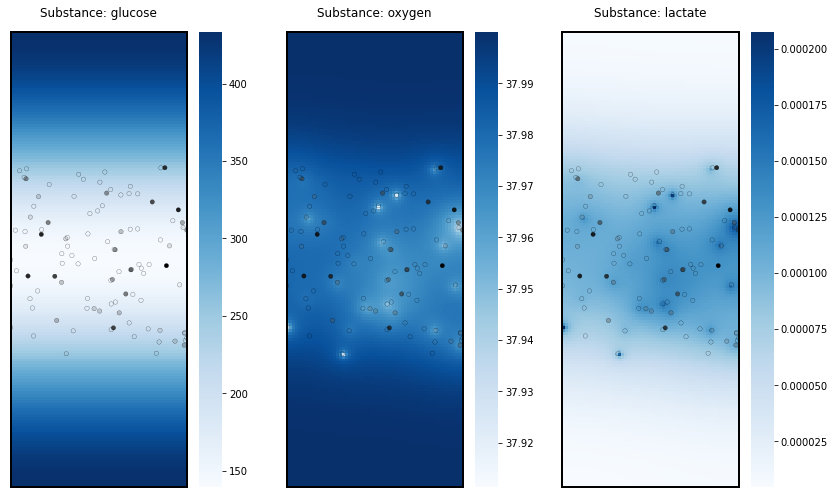

In [3]:
# Select the time point and the z-plane to visualize
time = 10
z_level = -10
cmap = 'Blues'
output_path = Path('output/')

# Read data
me = Microenvironment(time, output_path)

# Create a figure
fig, axes = plt.subplots(1, 3, figsize=(12, 7))

# Loop through each subfigure and match i with a substance
for ax_index, substance in enumerate(['glucose', 'oxygen', 'lactate']):
    
    # Select subfigure
    ax = axes[ax_index]
    # Plot the heatmap
    sns.heatmap(me.data[substance][z_level],
                ax=ax,
                xticklabels=False, yticklabels=False,
                cmap=cmap,
                square=True)
    
    # Get cell data to plot the cells' positions on top of the heatmap
    variables = ['position_x', 'position_y', 'position_z']
    cells = Cells(time, output_path).positions
    
    # Match the cells' real position to the heatmap structure 
    # (it is a grid with range of values inside the same grid space)
    # Real position limits
    x_mesh_bounds = [me.mesh[0].min(), me.mesh[0].max()]
    y_mesh_bounds = [me.mesh[1].min(), me.mesh[1].max()]
    # Heatmap limits
    x_bounds = [0, me.mesh[0].shape[0]]
    y_bounds = [0, me.mesh[1].shape[0]]
    # Interpolated coordinates
    # (the z position is still a work in progress, this is a preliminary approach)
    # (the goal is to have the transparency of the cells vary based on how close they are to the plane)
    positions = [(np.interp(x, x_mesh_bounds, x_bounds), 
                  np.interp(y, y_mesh_bounds, y_bounds), 
                  (1-abs(z)/(abs(z)+300)))
                 for x, y, z in cells]
    
    # Get the z values to be assigned to a value in the colormap
    alphas = np.array([position[2] for position in positions])
    # Choose colormap
    cell_cmap = plt.cm.binary
    # Get the colormap colors
    my_cmap = cell_cmap(np.arange(cell_cmap.N))
    # Set alpha
    my_cmap[:,-1] = np.concatenate((np.zeros(128), np.linspace(0, 1, 128)))
    # Create new colormap
    my_cmap = ListedColormap(my_cmap)
    
    # Plot the cells as circles (the radius, R, is just placeholder value for now)
    R = 0.75
    circles = [plt.Circle((position[0], position[1]), radius=R)
               for position in positions]
    col = PatchCollection(circles, edgecolor='black', linewidth=0.2, 
                          array=alphas.flatten(), cmap=my_cmap)
    ax.add_collection(col)
    
    # Figure style
    for _, spine in ax.spines.items():
        spine.set_visible(True)
        spine.set_linewidth(2)
        
    ax.set_title(f'Substance: {substance}', y=1.02)
    ax.invert_yaxis()
    
plt.tight_layout()

## Animations
Animations are helpful to understand the evolution of our simulated system over time. For simplicity, we will only be plotting the heatmaps and not the cells, but this approach could be used to create the previous plot style as well.

### Creating a GIF from PNG files
We can create an animation using the same strategy as before: for each time point we will be creating heatmaps and saving the plots as PNG files. Subsequently, once we have all the files, we can convert them into a GIF and remove the image files from our system so that we only end up with an animation. 

*Note: The output for this cell will not be shown here, but there should be a new GIF file in this notebook's directory once you run the cell.*

0

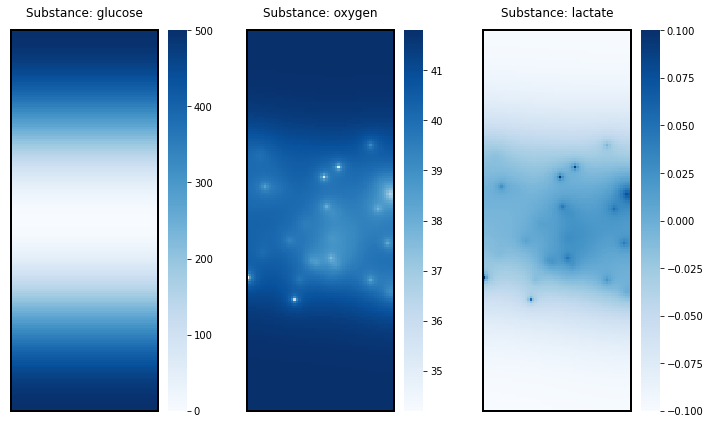

In [19]:
# Select the time point and the z-plane to visualize
number_of_timepoints = 10
z_level = -10
cmap = 'Blues'

# Create a figure
fig, axes = plt.subplots(1, 3, figsize=(12, 7))

# Loop through the timepoints
for time in range(number_of_timepointss):
    # Read data
    me = Microenvironment(time, output_path)
    
    # Loop through each subfigure and match i with a substance
    for ax_index, substance in enumerate(['glucose', 'oxygen', 'lactate']):

        # Select subfigure
        ax = axes[ax_index]
        # Plot the heatmap
        sns.heatmap(me.data[substance][z_level],
                    ax=ax,
                    xticklabels=False, yticklabels=False,
                    cmap=cmap, cbar=time==0,
                    square=True)

        # Figure style
        for _, spine in ax.spines.items():
            spine.set_visible(True)
            spine.set_linewidth(2)

        ax.set_title(f'Substance: {substance}', y=1.02)
        ax.invert_yaxis()
    
    # Save figure
    plt.savefig(f'time_{str(time).zfill(3)}.png')

# Create a GIF with the saved PNGs and then remove the image files
im_files = '*.png'
gif_name = 'output.gif'
subprocess.call(f'convert -delay 50 -loop 5 {im_files} {gif_name}', shell=True)
subprocess.call(f'rm {im_files}', shell=True)

### Animation widget
To see the animation online and be able to interact with it, we can use Jupyter widgets. This is a slightly different approach from before. We create two functions:
- `init()`, which is only run at the start of the simulation and that define the elements that will be kept constant over the animation (the colormap and colorbar)
- `my_func()`, which basically updates the existing heatmaps with the new values

In [25]:
%matplotlib inline
# Create figure
grid_kws = {'wspace': 0.35, 'hspace': 0.2}
fig, axes = plt.subplots(2, 2, gridspec_kw=grid_kws, figsize=(8, 8))
axes = axes.flatten()

def init():
    """Initial function to plot the first time point data and define the constant elements."""
    for substance_index, ax in enumerate(axes):
        me = Microenvironment(0, output_path)
        sns.heatmap(me.data[me.substances[substance_index]][0],
                    ax=axes[substance_index], cmap='magma',
                    xticklabels=False, yticklabels=False)
        
        ax.set_title(f'Substance: {me.substances[substance_index]}')

def my_func(i):
    """Update function to plot new values into the heatmap."""
    for substance_index, ax in enumerate(axes):
        me = Microenvironment(i, output_path)
        sns.heatmap(me.data[me.substances[substance_index]][i],
                    ax=axes[substance_index], cmap='magma',
                    xticklabels=False, yticklabels=False,
                    cbar=False)

        for _, spine in ax.spines.items():
            spine.set_visible(True)

# Create the animation using the previous function
anim = animation.FuncAnimation(fig=fig, func=my_func, init_func=init, 
                               frames=15, blit=False, repeat=False)

# Avoid duplicated results
plt.close()
# Visualize the animation
HTML(anim.to_jshtml())

## User selection
Lastly, going back to the approach where a single time point is represented, we can use a widget to allow users to select the time point and the z plane to visualize.

In [21]:
%matplotlib notebook

@interact(time=(0,10,1))
def plot_heatmaps(time=0, z=(-290,290,20)):
    me = Microenvironment(time, output_path)
    fig, axes = me.plot_heatmap(z)

    for ax in axes:
        for _, spine in ax.spines.items():
            spine.set_visible(True)
            spine.set_linewidth(1)

interactive(children=(IntSlider(value=0, description='time', max=10), IntSlider(value=-10, description='z', ma…